In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
# read data
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice']
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt', sep='\t', usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [3]:
# encode the categorical feature to number
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
# check if any null feature in samples
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
# only one sample has incomplete data, just remove
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

# Data Exploration

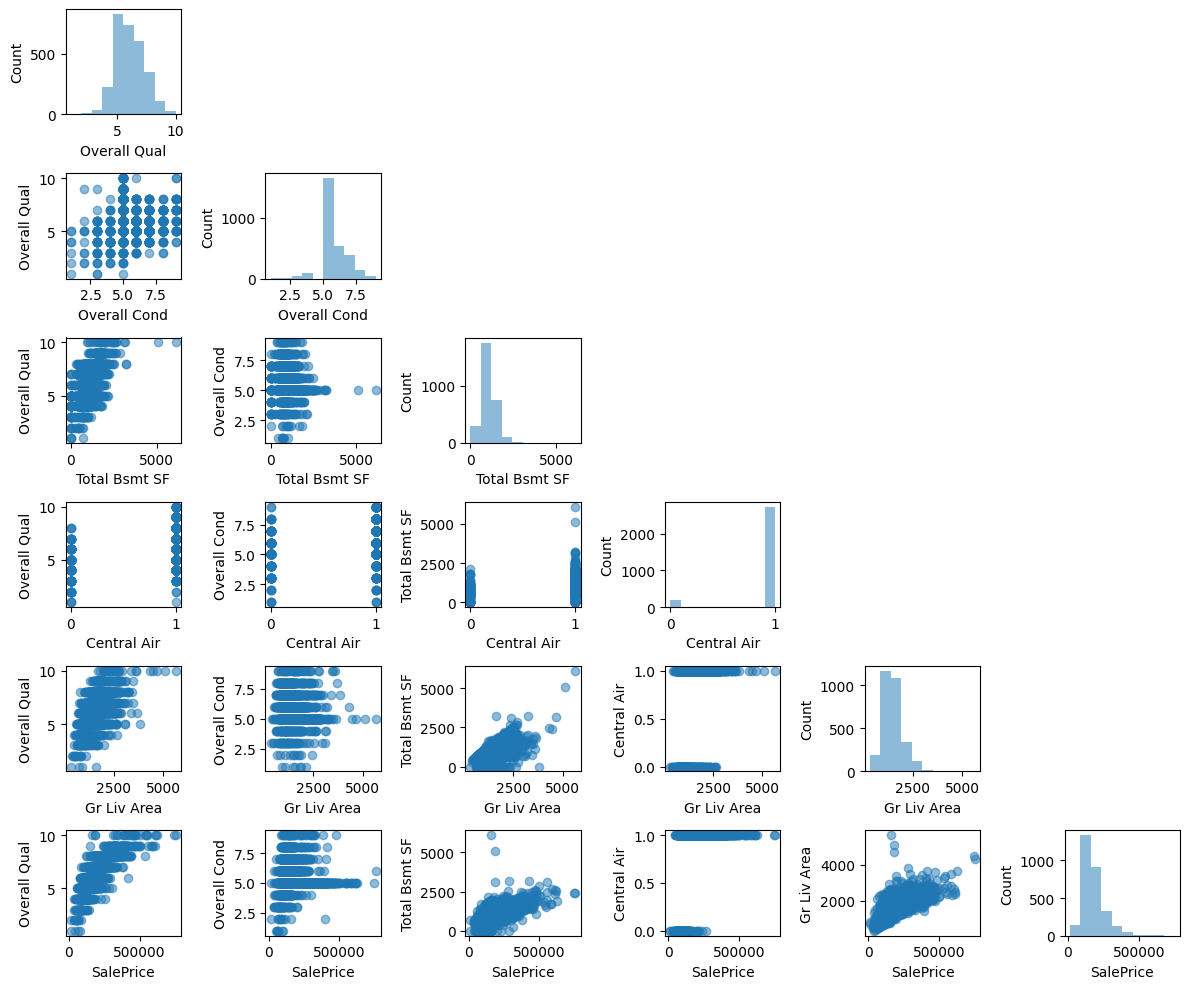

In [6]:
# Exploratory data analysis (EDA) is important to understand the data, detect outliers, distribution, and feature correlation, etc

# scatterplot matrix shows the correlation between features
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

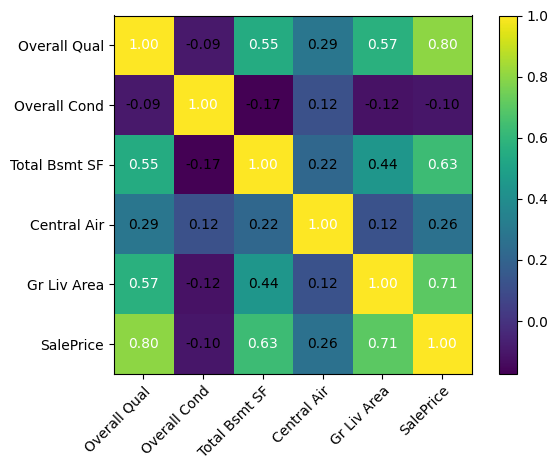

In [7]:
# show the correlation matrix heatmap to check any correlation between features
correlation_matrix = np.corrcoef(df.values.T)
heatmap = heatmap(correlation_matrix, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

# Linear Regression Model

In [8]:
# linear regression is just Adaline without the threshold function, i.e. just return model output without classifying to discrete labels

class LinearRegressionGD:

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta                      # learning rate
        self.n_iter = n_iter                # number of iterations on dataset
        self.random_state = random_state    # random generator key

    def fit(self, X, y):
         # generate random weights, size is same as number of features
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])

        # init bias to 0
        self.b_ = np.float_(0.)

        self.losses_ = []

         # iterate over dataset n_iter times
        for _ in range(self.n_iter):
            # calculate input for activation function
            net_input = self.net_input(X)
            # feed to activation function
            output = self.activation(net_input)
            # error = y_true - activation function output
            errors = y - output

            # update weights
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            # update bias
            self.b_ += self.eta * 2.0 * errors.mean()

            # MSE loss
            loss = (errors**2).mean()
            self.losses_.append(loss)
        
        return self

    def net_input(self, X):
        # z = wTx + b
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        # linear activation, just return input
        return X

    def predict(self, X):
        # regression just return model output
        return self.net_input(X)

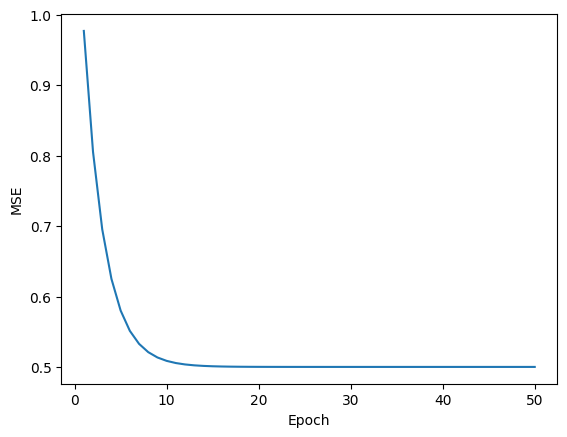

In [9]:
# use the living area feature, which seems to have a correlation with target
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

# standardize the feaure
sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)

# standardize the target too, since regression is continous target
sc_y = StandardScaler()
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

# train
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

# plot error vs train epoch
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

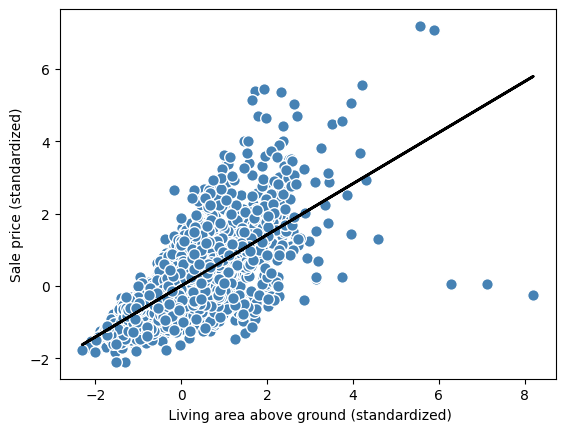

In [10]:
# function to plot the data, and the linear regression fitted line
def lin_reg_plot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

lin_reg_plot(X_std, y_std, lr)
plt.xlabel(' Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

In [11]:
# to get the target in original scale, just inverse transform
target_std = lr.predict(X_std[0])
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))

print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')

Sales price: $198262.06


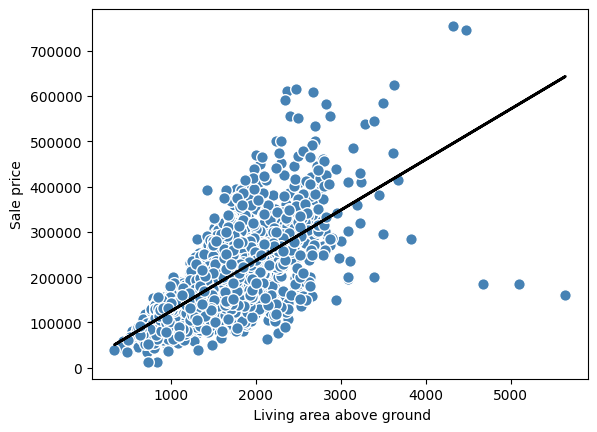

In [12]:
# or use sklearn, it does not need to standardize data
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)

lin_reg_plot(X, y, slr)
plt.xlabel(' Living area above ground')
plt.ylabel('Sale price')
plt.show()

# RANSAC

In [13]:
# ransac is less prone to outliers than linear regression, since it iteratively trains on subset of inlier data, and increase the inlier data gradually
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=0.95, residual_threshold=None, random_state=123)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

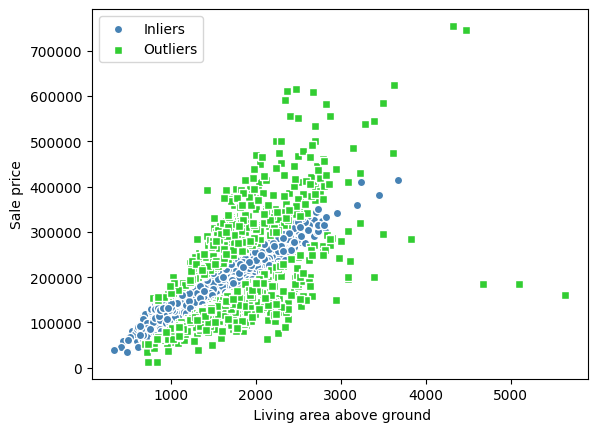

In [14]:
# plot inlier and outlier
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# plot inlier
plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolors='white', marker='o', label='Inliers')
# plot outlier
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolors='white', marker='s', label='Outliers')

plt.xlabel(' Living area above ground')
plt.ylabel('Sale price')
plt.legend(loc='upper left')
plt.tight_layout
plt.show()

# Evaluating Linear Regression Models

In [15]:
# use all 5 features instead of only 1
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

# train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# train
slr = LinearRegression()
slr.fit(X_train, y_train)

# predict
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

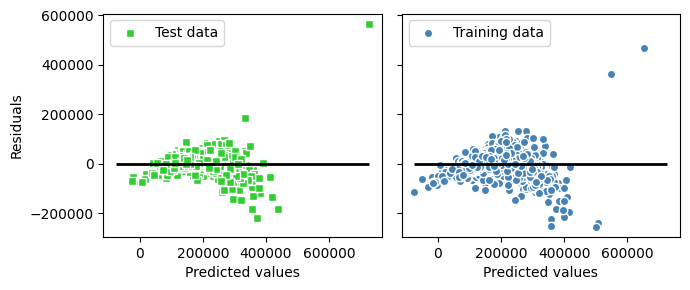

In [16]:
# residual (vertical distance between actual vs predicted value) plot is popular to visualize regression model performance

# get the max and min predicted values for specifying plot boundary
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# plot test set prediction residual
ax1.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
# plot train set prediction residual
ax2.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')

ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    # plot perfect prediction line (residual = 0)
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.show()

In [17]:
# MSE can be used to evaluate regression model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


In [18]:
# MAE could be more intuitive since it is same scale as the original target (not sqaured)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


In [19]:
# coefficent of determination (R2) is a standardized MSE, and is not affected of target scale as in MSE and MAE
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.3f}, {r2_test:.3f}')

R^2 train: 0.769, 0.752


# Polynomial Regression

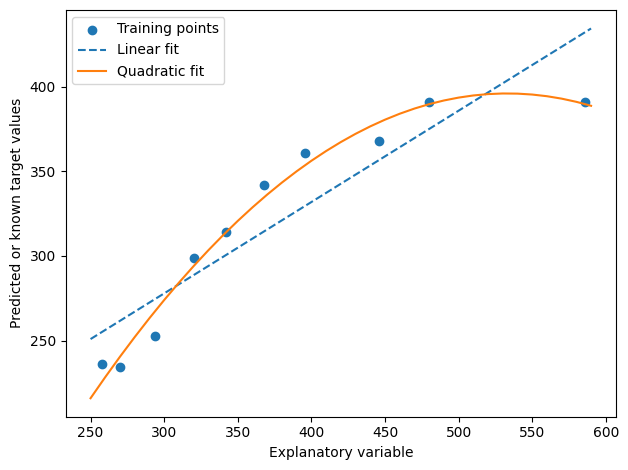

In [20]:
# polynomial regression adds polynomial terms, so the regression line does not have to be linear

# sample data
X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([ 236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])

# train the simple linear
lr = LinearRegression()
lr.fit(X, y)
# predict on some data
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_linear_fit = lr.predict(X_fit)

# add 2nd degree polynomial term, and transform the feature
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# train the polynomial regression model, i.e. by training on poly transformed data
pr = LinearRegression()
pr.fit(X_quad, y)
# predict on some data
y_quadratic_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot to check difference
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_linear_fit,
         label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quadratic_fit,
         label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# evaluate on MSE and R^2
y_linear_pred = lr.predict(X)
y_quadratic_pred = pr.predict(X_quad)

mse_linear = mean_squared_error(y, y_linear_pred)
mse_quad = mean_squared_error(y, y_quadratic_pred)
print(f'Training MSE linear: {mse_linear:.3f}, quadratic: {mse_quad:.3f}')

r2_linear = r2_score(y, y_linear_pred)
r2_quad = r2_score(y, y_quadratic_pred)
print(f'Training R^2 linear: {r2_linear:.3f}, quadratic: {r2_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


In [22]:
# read in data, only use 1 feature
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

# remove some outliers from the dataset
X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]

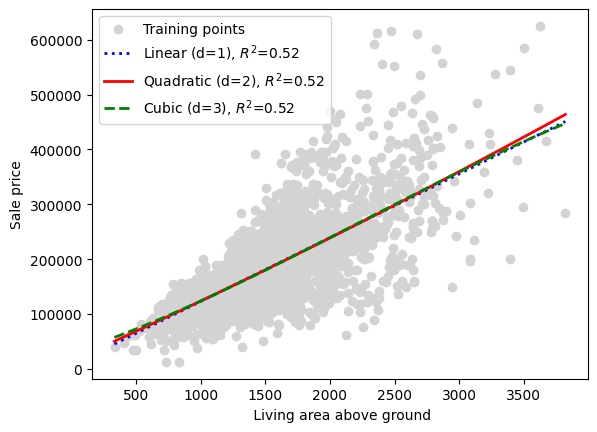

In [24]:
# base regression model to fit on linear, quadratic, cubic data
regression = LinearRegression()

# create quadratic and cubic data for polynomial regression
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear regression
linear_regression = regression.fit(X, y)
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]  # data for plotting regression line
y_linear_fit = linear_regression.predict(X_fit)
linear_r2 = r2_score(y, linear_regression.predict(X))

# quadratic regression
quadratic_regression = regression.fit(X_quad, y)
y_quad_fit = quadratic_regression.predict(quadratic.fit_transform(X_fit))
quad_r2 = r2_score(y, quadratic_regression.predict(X_quad))

# cubic regression
cubic_regression = regression.fit(X_cubic, y)
y_cubic_fit = cubic_regression.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, cubic_regression.predict(X_cubic))

# plot training data
plt.scatter(X, y, label='Training points', color='lightgray')
# plot models
plt.plot(X_fit, y_linear_fit, label=f'Linear (d=1), $R^2$={linear_r2:.2f}', color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label=f'Quadratic (d=2), $R^2$={quad_r2:.2f}', color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}', color='green', lw=2, linestyle='--')
plt.xlabel(' Living area above ground')
plt.ylabel('Sale price')
plt.legend(loc='upper left')
plt.tight_layout
plt.show()


# Tree and Forest Regression

Text(0, 0.5, 'Sale price')

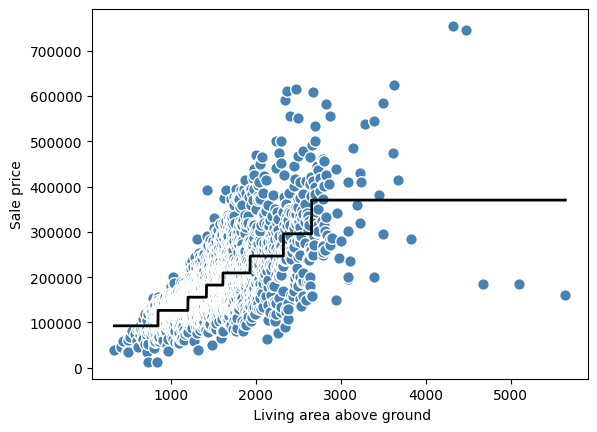

In [26]:
# read in data, only use 1 feature
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()
lin_reg_plot(X[sort_idx], y[sort_idx], tree)
plt.xlabel(' Living area above ground')
plt.ylabel('Sale price')

In [28]:
# use all 5 features instead of only 1
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

# train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# forest regression uses MSE
forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# evaluate
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


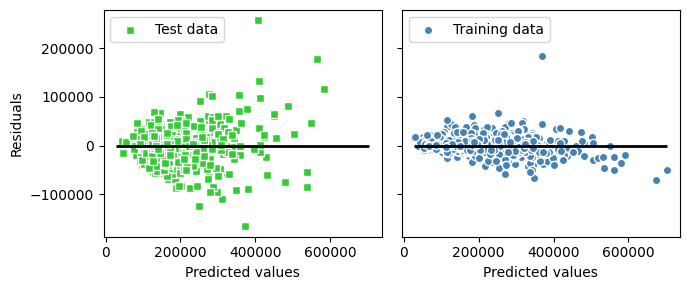

In [29]:
# plot residual
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,
              color='black', lw=2)
plt.tight_layout()
plt.show()